## Bank Customer Churn Prediction


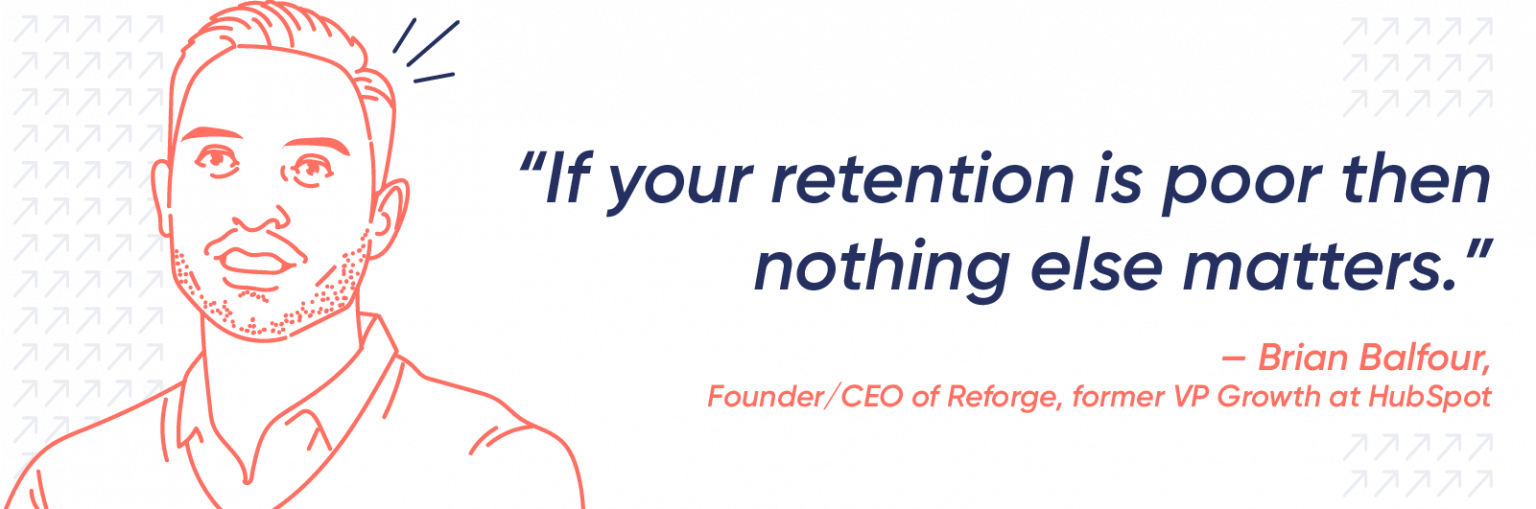

## 1. Introduction


Every business deals with customer churn. It is one of the top business priorities. 

**Customer churn**, also known as customer attrition, refers to "a degree of inactivity or disengagement observed given a period of time". There are usualy early indicators which could be uncovered from relational or behavioral data with churn analysis. To understand key drivers of customer churn and to be abe to identify at-risk customers is crucial to many aspects of business development, from **revenue growth** to **acquisition campaign ROI**. Normally, loyal, long-term customers spend 90% more often and buy 90% more per transaction. Hence it's always worth business attention to investigate on how to retain existing customers and prevent churn. 

### For this project, I aim to accomplish these two objectives : 
- 1. Diagnose key factors of customer churn
- 2. Build a model to identify at-risk customers (likely to churn)


### Content

- 1. Introduction
- 2. Data Preparation
- 3. Explorative Data Analysis (EDA)
- 4. Feature Engineering
- 5. Model Selection
- 6. Feature Selection
- 7. Summary

I kicked off this project by first looking into internal structure of input data. Some statistic analysis and visualization techniques are used to explore numeric and categorical features in the dataset. A bunch of interesting insights were extracted from data (numeric, categorical). 

The feature engineering part includes a set of numeric scaling (normalization) and categorical transformation (onehotencoding, ordinal encodring). Some new features were believed to have contribution to predicting target values, thus added to the feature space. 

### Classification Models 
As for model selection, I tried the following six classification models:
- 1. Logistic Regression 
- 2. Polynomial Logistic Regression (degree =2)
- 3. Support Vecotr Machine (RBF Kernel)
- 4. Support Vecotr Machine (Poly Kernel)
- 5. Random Forest 
- 6. Extreme Gradient Boosting Machine

K-fold cross validation and grid search methods are utilized at model selection stages. Since it is of greate significance for the model to ba able to identify as many churned customers as possbile, recall is more valued among other evaluation metrics (precision, accuracy, f1 score, auc score). 

## 2. Data Preparation

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# read csv data file
df = pd.read_csv('Bank Churn Data.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
# check the size of dataframe
df.shape

(10000, 14)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Remark**:
The dataframe has 10000 rows and 14 columns, of which 3 are categorical and 11 are numeric. 
It is of my interest to further review these attributes, aiming to identify which attributes are essential and which are less valuable.  

In [32]:
# check missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Remark**:
There are no missing values. Very surprised. It is pretty rare but okay!

In [33]:
# check unique count 
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

**Remark**: RowNumber and CustomerID could be removed as both are specific to a customer and fail to provide value-added information in identifying potential customers who churned. Surname is likely to cause profiling, thus preferably to be excluded. Exited column is target variable. 


In [34]:
df=df.drop(["RowNumber","CustomerId","Surname"], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 3. Exploratory Data Analysis

In [35]:
# First, we check proportion of customer churned and retained.
target_count=df["Exited"].value_counts(normalize=True)
print(target_count)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


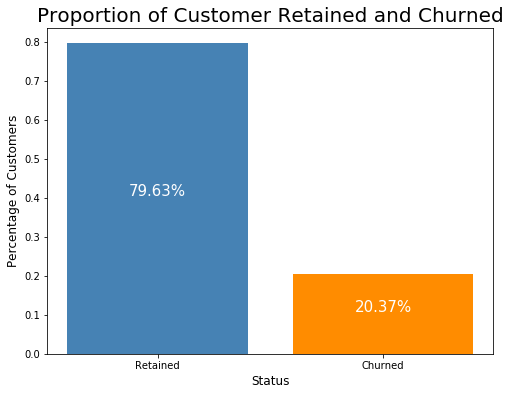

In [36]:
fig,ax=plt.subplots(figsize=(8,6))
ax.bar(target_count.index, 
       target_count, 
       color=["steelblue", "darkorange"],
      tick_label=["Retained", "Churned"])
ax.set_xlabel("Status", fontsize=12)
ax.set_ylabel("Percentage of Customers", fontsize=12)
ax.set_title("Proportion of Customer Retained and Churned", fontsize=20)
for i, v in enumerate(target_count):
    ax.text(i, v*0.5, "%.2f"%(v*100)+"%", 
            fontsize=15, color="white", 
            va="bottom",ha="center")
plt.show()

**Remarks**: It seems that 20% of customers in the dataset churned. It marks a baseline for the models to identify at least 20% of customers as churners. 

**Remarks**: Obviously, accuracy is an important metric to measure a model's classification skills. In this project, the final model is expected to identify these 20% churners as accurately as possible. This is considered as more valuable than accurately predicting customer who did not churn.

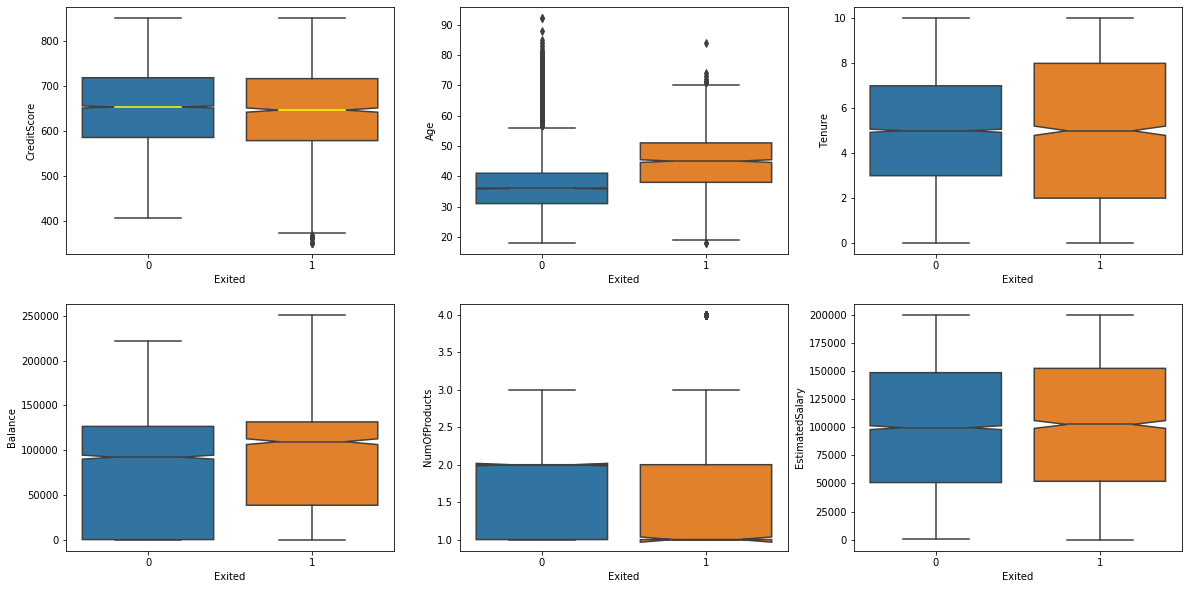

In [37]:
# Second, let's review target variable's relationship with numeric varaibles
_,axss = plt.subplots(2,3, figsize=[20,10]) 
numeric_val=["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
for i, n in enumerate(numeric_val):
    sns.boxplot(x='Exited', y =n, notch=True, data=df, ax=axss[i//3][i%3])
    for line in axss[0][0].get_lines()[4::12]:
        line.set_color('yellow')
    for line in axss[0][0].get_lines()[10::12]:
        line.set_color('yellow')

#### **Remark**: 
* **Credit Score**: <br/>
Both retained and churned customers have similar median and spread in the credit score distribution. 
* **Age**: <br/>
Among customers who churned, half of them are middle-aged (45+) or considered gerontic (70). Oppositely, customers who retained are generally quite young, with 75% aged under 40. Chances are that the bank is having a service preference towards differnet age categories. We could advice the bank to review its market strategy and customer services between different age groups for further validation. 
* **Tenure**:<br/>
As for tenure, churned and retained customers share similar min, max and median. But we found that, the customers closer to either extreme end (too little or too large) are more likely to churn, compared with those with average tenure lengths. 
* **Balance**:<br/>
From the graph, it is apparent that 50% of churners' balance is higher than 1000, while 50% of non-churners' is lower than 1000. Also,since the notches of two boxes do not overlap, there is a strong evidence (95% confidence interval) that their medians differ. The maximun balance of churner could go as high as 250 thousands, while the highest balance of non churners is only aroud 225 thousands. <br/> All the numbers allude to that the bank seems to lose customer with significant bank balance.   
* **Number of Product**:<br/>
Number of product does not seem to differentiate churned and retained customers properly. We could apply some transformation techniques to further explore its relation with the target, i.e. standardization. 
* **Estimated Salary**:<br/>
Estimated Salary does not seem to differentiate churned and retained customers properly. We could apply some transformation techniques to further explore its relation with the target, i.e. standardization. 

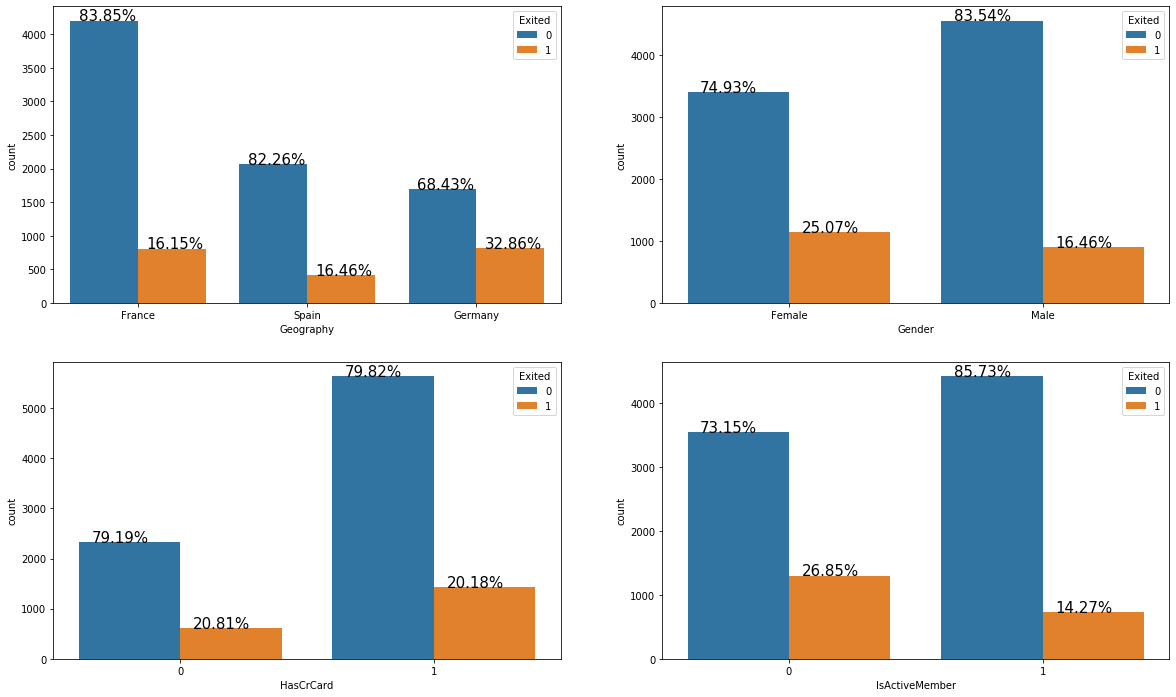

In [38]:
# Third, let's review target variable's relationship with categorical features
_,axss = plt.subplots(2,2, figsize=[20,12])
categorical_val=["Geography", "Gender","HasCrCard","IsActiveMember"]

# Define a function to add percentage on top of bars
def with_hue(plot,feature, number_of_categories, hue_categories):

    # get batches from graph
    a=[p.get_height() for p in plot.patches]
    patch=[p for p in plot.patches]
    
    for i in range(hue_categories):
        for j in range(num_of_categories):
            
            # specify which category to annotate
            cats=np.sort(feature.unique())[j]
            # total counts of the category
            total=df[feature==cats]["Exited"].count()      
            
            # get the index of which patch to annotate 
            id=i*num_of_categories+j
            # get the value corresponding to the patch
            number=a[id]
            # get proportion of the patch in the category it belongs to 
            pct= "{:.2f}%".format(round(100*(a[id]/total),2))
    
            # get x, y coordinate of annotation
            x=patch[id].get_x()+patch[id].get_width()/2-0.15
            y=patch[id].get_y()+patch[id].get_height()
            plot.annotate(pct, (x,y), size=15)

for i, n in enumerate(categorical_val):
    ax_=axss[i//2][i%2]
    sns.countplot(x=n, hue="Exited", data=df, ax=ax_)      
    num_of_categories= df[str(n)].nunique()
    hue_categories=df["Exited"].nunique()
    with_hue(ax_, df[str(n)], num_of_categories, hue_categories)
    
plt.show()


**Remark**:
* **Geography**: <br/>
The majority of customers are from France, with Spain and Germany having a relatively equal number of customers. Interestingly, Germany has the highest churn rate (over 50%) with the lowest customer numbers, while France has the least churn rate (less than 20%) with the largest customer community. A thought emerged in my mind that there might be a problem for areas with less significant customer foundation (i.e. lack of services, product choices or support), which resulted in high churn rates. 

* **Gender**:
Female customers seem to churn more than male customers. The number of female customers is close to the number of the male.

* **HasCrCard**:
The majority of customers have credit cards. Churn rates between customers with credit cards and those without are almost the same (40%).It seems that this feature does not affect the identification of the target (Exited) to a noticable extent. 

* **IsActiveMember**:
Customers who are non-active members are more likely to churn (35.6%) than those who are active (16.5%), which kinda make sense. I am a bit concerned about the proportion of non-active members, which are quite high. Also, if I can get more descriptive information for "activeness" (i.e. its definition, measurement criteria, whether there are different degress), I could give it a further review from this perspective. 

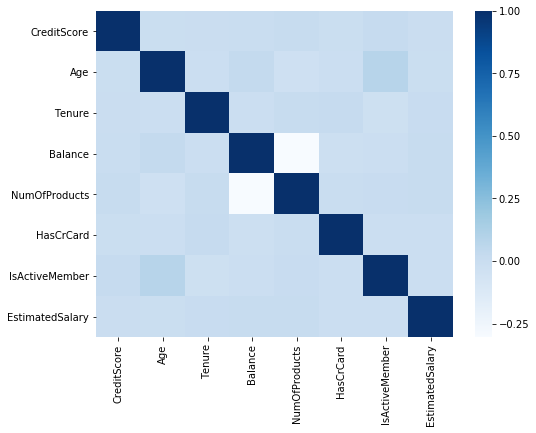

In [39]:
# Forth, let's check pairwise correlation of variables
corr_score = df.loc[:, df.columns != "Exited"].corr(method="pearson")
# visualization of correlation scores
plt.subplots(figsize=(8,6))
sns.heatmap(corr_score, cmap="Blues")
plt.show()

**Remark**: As shown in heatmap, a few of variables seem to have certain dependency with "Age", such as "Balance", "Number of Product", "HasCrCard" and "IsActiveMember". It does make sense that, elder people have more available capital to put in their accounts or more free time to be engaged with the account managers. But we need to validate this assumption. Let's look at specific scores for a double-check. 

In [40]:
corr_score

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000


In [41]:
corr_score[abs(corr_score)>0.1]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
CreditScore,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Balance,NaN,NaN,NaN,1.00000,-0.30418,NaN,NaN,NaN
NumOfProducts,NaN,NaN,NaN,-0.30418,1.00000,NaN,NaN,NaN
HasCrCard,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
IsActiveMember,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
EstimatedSalary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


**Remark**: Obviously, colour contrast could be misleading sometimes. Except for a low degree of negative correlation between NumOfProducts and Balance (-0.30418), none of the rest have any noticible and significant correlations. Since -0.30418 is quite low, we will keep both variables. 

## 4. Feature Engineering

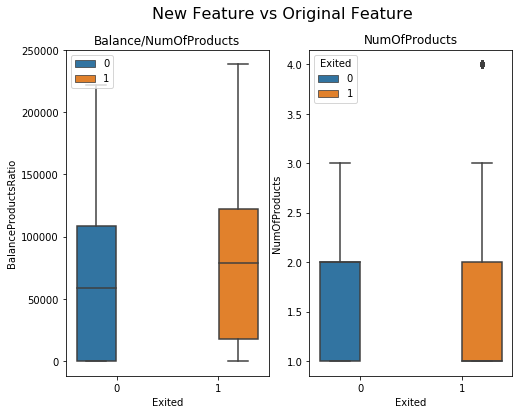

In [42]:
# we will explore some new feaures that can provide value-added information to prediction
# start by adding new feature, the ratio of balance to number of products
df["BalanceProductsRatio"]=df.Balance/df.NumOfProducts
fig,axes=plt.subplots(1,2,figsize=(8,6))
ax1=axes[0]
ax2=axes[1]
sns.boxplot(y="BalanceProductsRatio", x="Exited", hue="Exited", data=df, ax=ax1)
sns.boxplot(y="NumOfProducts", x="Exited", hue="Exited", data=df, ax=ax2)
ax1.legend(loc="upper left")
ax1.set_title("Balance/NumOfProducts")
ax2.set_title("NumOfProducts")

fig.suptitle("New Feature vs Original Feature", fontsize=16)
plt.show()

**Remark**: We noticed NumOfProducts has little effect on prediction of customer churning. But we found that, the ratio of balance and number of products seems to differ between the retained and the churned. 

As shown on the left, customers with higher balance product ratio churn more than those with lower ratio scores. Thus we add this as a new feature. 

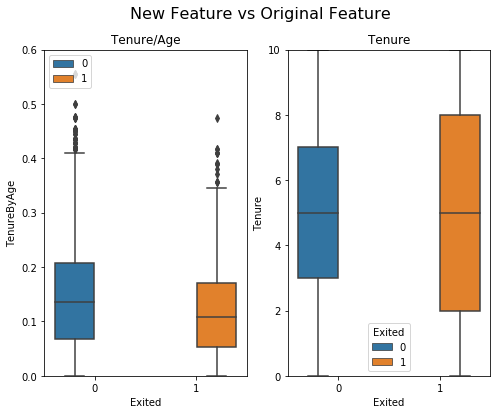

In [43]:
# add another feature, the ratio of tenure to age
df["TenureByAge"]=df.Tenure/df.Age
fig,axes=plt.subplots(1,2,figsize=(8,6))
ax1=axes[0]
ax2=axes[1]
sns.boxplot(y="TenureByAge", x="Exited", hue="Exited", data=df, ax=ax1)
sns.boxplot(y="Tenure", x="Exited", hue="Exited", data=df, ax=ax2)
ax1.legend(loc="upper left")
ax1.set_title("Tenure/Age")
ax1.set_ylim(0,0.6)
ax2.set_title("Tenure")
ax2.set_ylim(0,10)

fig.suptitle("New Feature vs Original Feature", fontsize=16)

plt.show()

**Remark**: Similaryly, as tenure does not seem make much impact on identifying custoner churn and tenure can be an "indicator" of age, we standardize the tenure with age and also add it as a new feature. 

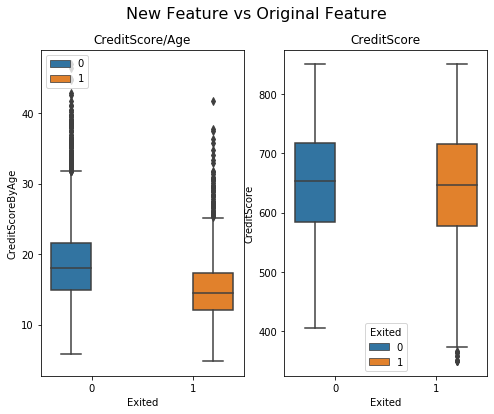

In [44]:
# add a third new feature, the ratio of credit score to age
df["CreditScoreByAge"]=df.CreditScore/df.Age
fig,axes=plt.subplots(1,2,figsize=(8,6))
ax1=axes[0]
ax2=axes[1]
sns.boxplot(y="CreditScoreByAge", x="Exited", hue="Exited", data=df, ax=ax1)
sns.boxplot(y="CreditScore", x="Exited", hue="Exited", data=df, ax=ax2)
ax1.legend(loc="upper left")
ax1.set_title("CreditScore/Age")
ax2.set_title("CreditScore")

fig.suptitle("New Feature vs Original Feature", fontsize=16)

plt.show()

**Remark**: To our common sense that older adults have significantly higher credibility level than juniors. Likewise, we put a new feature taking into account credit score with regard to ages. This will be the third additionally added features.  

In [45]:
# divide data into training and testing set.
from sklearn import model_selection
X=df.drop("Exited", axis=1)
y=df.loc[:,"Exited"]

X_train, X_test, y_train, y_test=model_selection.train_test_split(X,y, test_size=0.25,stratify=y, random_state=43)

print("Training dataset has "+ str(X_train.shape[0]) + " observation with " + str(X_train.shape[1]) +" features") 
print("Testing dataset has "+ str(X_test.shape[0]) +" observation with " + str(X_test.shape[1]) +" features") 

Training dataset has 7500 observation with 13 features
Testing dataset has 2500 observation with 13 features


In [46]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

# we will perform some categorical encoding. 
# apply one hot encoding to categorical variables
def OneHotEncoding(df, enc, categories):
    transformed=pd.DataFrame(enc.fit_transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True),transformed], axis=1).drop(categories,axis=1)

category=["Geography"]
enc=OneHotEncoder().fit(X_train[category])
X_train=OneHotEncoding(X_train, enc, category)
X_test=OneHotEncoding(X_test, enc, category)


In [47]:
# ensure that ll OneHotEncoding variables that appear in the train data appear in the test data
L=list(set(X_train.columns)-set(X_test.columns))
for l in L:
    X_test[str(l)]=0

In [48]:
# apply ordinal encoding to categorical variable
X_train[["Gender"]]=OrdinalEncoder().fit_transform(X_train[["Gender"]])
X_test[["Gender"]]=OrdinalEncoder().fit_transform(X_test[["Gender"]])

In [49]:
# we will apply some numeric scaling 
# perform MinMax scaling to the continuous variables to values in the range[0,1]
def MinMaxScaling(df,continuos,minVec, maxVec):
    df[continuous_vars]= (df[continuous_vars]-minVec)/(maxVec-minVec)
    return df

continuous_vars=["CreditScore", "Age", "Tenure",
                 "Balance","NumOfProducts","EstimatedSalary",
                 "BalanceProductsRatio", "TenureByAge",
                 "CreditScoreByAge"]
minVec=X_train[continuous_vars].min().copy()
maxVec=X_train[continuous_vars].max().copy()
X_train=MinMaxScaling(X_train, continuous_vars, minVec, maxVec)
# perform MinMax scaling to continuous variables in test data based on min and max from train data
X_test=MinMaxScaling(X_test, continuous_vars, minVec, maxVec)

In [50]:
print(X_train.shape)
print(X_test.shape)

(7500, 15)
(2500, 15)


## 5. Model Selection

**Remarks**: For the model fitting, I will try out the follwing five models:
- Logistic Regression (primal space with different kernels)
- K-Nearest Neighbours
- SVM (primal space with different kernels)
- Random Forest 
- Extreme Gradient Boosting Machine

In [54]:
# import XGBoost
import sys
!{sys.executable} -m pip install xgboost

In [55]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [56]:
# import support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# fit models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier

# import scoreing functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [178]:
# Functionsf to give best model and parameters
def best_model(model):
    print("Best score:"+str(model.best_score_))
    print("Best parameters:"+str(model.best_params_))
    print("Best estimator:"+str(model.best_estimator_))
def get_auc_scores(y_tru, y_score):
    auc_score=roc_auc_score(y_tru, y_score)
    fpr_df, tpr_df, thres =roc_curve(y_tru,y_score)
    return (auc_score, fpr_df, tpr_df)
    

In [58]:
# fit primal logistic regression
param_grid={"C":[0.1,0.5,1,10,50,100],
           "max_iter":[250],
           "fit_intercept":[True],
           "intercept_scaling":[1],
           "penalty":["l2"],
           "tol":[0.00001, 0.0001, 0.000001]}
log_primal_Grid=GridSearchCV(LogisticRegression(solver="lbfgs"),
                                               param_grid,cv=10,
                                               refit=True, verbose=0)
log_primal_Grid.fit(X_train, y_train)
best_model(log_primal_Grid)

Best score:0.8156
Best parameters:{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
Best estimator:LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


**Remark**: Explain hyperparameters of Logistic Regression
- **C**: inverse of regularization strength (=1/regularization coefficient = 1/lambda)
- **max_iter**: max number of iterations for solver to converge
- **fit_intercept**: whether a constant will be added to decision function
- **intercept_scaling**: append a constant (equal to intercept_scaling) to instance vector x (useful only the solver="liblinear" and fit_intercept=True)
- **penalty**: specify norm used in penalization, "lbfgs" (and "newtonw-cg","sag") can only accept "l2")
- **tol**: tolerance for stopping, when error is less than tol stop further computing. 

GridSearchCV hyperparameters explanation:
- **refit**: refit an estimator using the use parameters on the whole dataset. The refitted estimator is available at the best_estimator_ and permits using predict directly on GridSearchCV
- **verbose**: the higher ,the more messages.
     - if >1, shows computation time for each fold and parameter candidates. 
     - if >2, add scores
     - if >3, add fold and parameter candidate index, starting time of computation

In [59]:
# fit logistic regression with degree 2 polynomial kernel
param_grid={"C":[0.1,10,100],
           "max_iter":[300, 500,1000],
           "fit_intercept":[True],
           "intercept_scaling":[1],
           "penalty":["l2"],
           "tol":[0.0001, 0.000001]}
poly2=PolynomialFeatures(degree=2)
X_train_poly2=poly2.fit_transform(X_train)
log_poly2_Grid=GridSearchCV(LogisticRegression(solver="lbfgs"),
                                               param_grid,cv=10,
                                               refit=True, verbose=0)
log_poly2_Grid.fit(X_train_poly2, y_train)
best_model(log_poly2_Grid)

Best score:0.8566666666666667
Best parameters:{'C': 100, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
Best estimator:LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [64]:
# fit svm with RBF kernel
param_grid={"C":[0.5,100,150],
           "gamma": [0.1,0.01,0.001],
           "probability":[True],
           "kernel":["rbf"]}
SVM_grid=GridSearchCV(SVC(), param_grid, cv=3,
                     refit=True, verbose=0)
SVM_grid.fit(X_train, y_train)
best_model(SVM_grid)

Best score:0.8513333333333334
Best parameters:{'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
Best estimator:SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


**Remark**: Explain hyperparameters of SVC 
Support Vector Classification
- **C**:inverse regularization strength (l2 penalty)
- **gamma**: kernel coefficients for "rbf", "poly" and "sigmoid"
- **probability**: whether to enable probability estimate
- **kernel**: default "rbf", else include "linear","poly","sigmoid" amd "precomputed"

In [65]:
# fit svm with poly kernel
param_grid={"C":[0.5,1,10,50,100,150],
           "gamma": [0.1,0.01,0.001],
           "probability":[True],
           "kernel":["poly"],
           "degree":[2,3]}
SVM_poly_grid=GridSearchCV(SVC(), param_grid, cv=3,
                     refit=True, verbose=0)
SVM_poly_grid.fit(X_train, y_train)
best_model(SVM_poly_grid)

Best score:0.8509333333333333
Best parameters:{'C': 150, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
Best estimator:SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [68]:
# fit random forest classifier
param_grid={"max_depth":[3,5,7,9,10],
           "max_features":[2,4,6,8,9],
           "n_estimators":[50,100],
           "min_samples_split":[3,5,7,8]}
RF_grid=GridSearchCV(RandomForestClassifier(),
                    param_grid, cv=5, refit=True, verbose=0)
RF_grid.fit(X_train, y_train)
best_model(RF_grid)

Best score:0.8638666666666667
Best parameters:{'max_depth': 10, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 100}
Best estimator:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Remark**: Explain hyperparameters of Random Forest 
Random Forest
- **max_depth**: max depth of the tree
- **max_features**: max number of features to consider at each split when looking for the best split (criteria could be "gini" or "entropy")
- **n_estimators**: number of trees in the forest
- **min_samples_split**: min number of samples required to split a node

In [69]:
# fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 
              'gamma': [0.01,0.001,0.001],
              'min_child_weight':[1,5,10], 
              'learning_rate': [0.05,0.1, 0.2, 0.3], 
              'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), 
                        param_grid, cv=5, 
                        refit=True, verbose=0)
xgb_grid.fit(X_train, y_train)
best_model(xgb_grid)

Best score:0.8625333333333334
Best parameters:{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
Best estimator:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


**Remark**: Explain hyperparameters of XGBoost
Random Forest
- **max_depth**: max tree depth for base learners
- **gamma**: minimum loss reduction required to make a further partition on a leaf node of the tree
- **min_child_weight**: minimum sum of instance weight (hessian) neede in a child
- **learning_rate**: learning rate shrinks the contribution of each tree by learning rate. There is a trade off between n_estimators and learning rate.
- **n_estimators**: number of boosting stages to perform 

In [83]:
# fit all six best models
models=[log_primal_Grid,
       log_poly2_Grid,
       SVM_grid, SVM_poly_grid,
       RF_grid, xgb_grid]

model_names=["Logistic regression",
            "Polynomial logistic regression",
            "RBF SVM",
            "Poly SVM",
            "Random forest",
            "XGBoost"]
for model, name in zip(models, model_names):
    best_model=model.best_estimator_
    if model ==log_poly2_Grid:
        best_model=best_model.fit(X_train_poly2, y_train)
    else:
        best_model=best_model.fit(X_train, y_train)
    print("Best model of "+ str(name)+" is refitted.")

Best model of Logistic regression is refitted.
Best model of Polynomial logistic regression is refitted.
Best model of RBF SVM is refitted.
Best model of Poly SVM is refitted.
Best model of Random forest is refitted.
Best model of XGBoost is refitted.


In [113]:
# review model performance metrics (accuracy, recall, F1 score) on train dataset
def cal_evaluation(models, model_names,data1, data2, target):
    for model, name in zip(models, model_names):
        if model == log_poly2_Grid:
            cm=confusion_matrix(target, model.predict(data2))
        else:
            cm=confusion_matrix(target, model.predict(data1))
        tn=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tp=cm[1][1]
        accuracy=(tp+tn)/(tp+tn+fp+fn+0.0)
        precision=tp/(tp+fp+0.0)
        recall=tp/(tp+fn+0.0)
        print(name)
        print("Accuracy is: "+str(accuracy))
        print("Precision is: "+str(precision))
        print("Recall is: "+str(recall))
        print("-------------------")
        
cal_evaluation(models, model_names,X_train,X_train_poly2, y_train)

Logistic regression
Accuracy is: 0.8165333333333333
Precision is: 0.6455938697318008
Recall is: 0.2205497382198953
-------------------
Polynomial logistic regression
Accuracy is: 0.8625333333333334
Precision is: 0.7596656217345873
Recall is: 0.4757853403141361
-------------------
RBF SVM
Accuracy is: 0.8577333333333333
Precision is: 0.8335745296671491
Recall is: 0.3769633507853403
-------------------
Poly SVM
Accuracy is: 0.8533333333333334
Precision is: 0.8451612903225807
Recall is: 0.34293193717277487
-------------------
Random forest
Accuracy is: 0.8989333333333334
Precision is: 0.9130901287553648
Recall is: 0.5569371727748691
-------------------
XGBoost
Accuracy is: 0.8874666666666666
Precision is: 0.8475609756097561
Recall is: 0.5458115183246073
-------------------


**Remark**: The main purpose of this task is to identify as many churned customers as possible. The more, the better. Therefore, recall is of more importance to us. 

In this casel, recall is the number of churned customers identified by the model divided by the total number of customers who actually churned, as expressed in formula: Recall = True Positive / (True Positive + False Negative). 

From the results above, Random Forest has the highest recall (0.56) on the 1's, which indicates that the model could identify more than half of customers who actually churned. It also has the highest precision (0.91) on the 1's, meaning that out of all customers which the model thinks will churn, 91% do actually churned. 

In [108]:
# review model performance metrics (classification report) on train dataset
def cal_report(models, model_names, data1, data2, target):
    for model, name in zip(models, model_names):
        if model== log_poly2_Grid:
            class_repo=classification_report(target, model.predict(data2))
        else:
            class_repo=classification_report(target, model.predict(data1))
        print(name)
        print(class_repo)
        print("-------------------")
        
cal_report(models,model_names,X_train, X_train_poly2, y_train)


Logistic regression
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      5972
           1       0.65      0.22      0.33      1528

    accuracy                           0.82      7500
   macro avg       0.74      0.59      0.61      7500
weighted avg       0.79      0.82      0.78      7500

-------------------
Polynomial logistic regression
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5972
           1       0.76      0.48      0.59      1528

    accuracy                           0.86      7500
   macro avg       0.82      0.72      0.75      7500
weighted avg       0.85      0.86      0.85      7500

-------------------
RBF SVM
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5972
           1       0.83      0.38      0.52      1528

    accuracy                           0.86      7500
   macro avg       0.85      

**Remark**: We mostly want to check the f1-score, whose formula is 2*(Precision * Recall)/ (Precision+ Recall). 

Considering that wrongly identifying customers who are actually not planing to leave as at-risk customers, thus putting them to a scheme (i.e. send coupon/text, give more customer services/follow-up) might increase customer service budget, we might want to have a high precision (low false positives) as well. To strike a balance between recall and precision, we can turn to F1 score. 

Surprisingly, it is the random forest that has the hgihest f-1 score (0.69). 

In [133]:
# check ROC curve and AUC score on train dataset
auc_scores={}
fpr_set={}
tpr_set={}

def cal_auc_roc(models, model_names, data1, data2, target, scores, fprs, tprs):
    for model, name in zip(models, model_names):
        if model == log_poly2_Grid:
            auc,fpr,tpr=get_auc_scores(target, model.predict_proba(data2)[:,1])
        else:
            auc,fpr,tpr=get_auc_scores(target, model.predict_proba(data1)[:,1])
        
        print(name)
        scores[str(name)]=auc
        fprs[str(name)]=fpr
        tprs[str(name)]=tpr
        print("AUC score: "+ str(auc))
        print("-------------------")

cal_auc_roc(models, model_names, X_train, X_train_poly2, y_train, auc_scores, fpr_set, tpr_set)



Logistic regression
AUC score: 0.7714165889333469
-------------------
Polynomial logistic regression
AUC score: 0.870387287270789
-------------------
RBF SVM
AUC score: 0.8522464564126482
-------------------
Poly SVM
AUC score: 0.8356716158828459
-------------------
Random forest
AUC score: 0.9555383675301494
-------------------
XGBoost
AUC score: 0.9254331075560294
-------------------


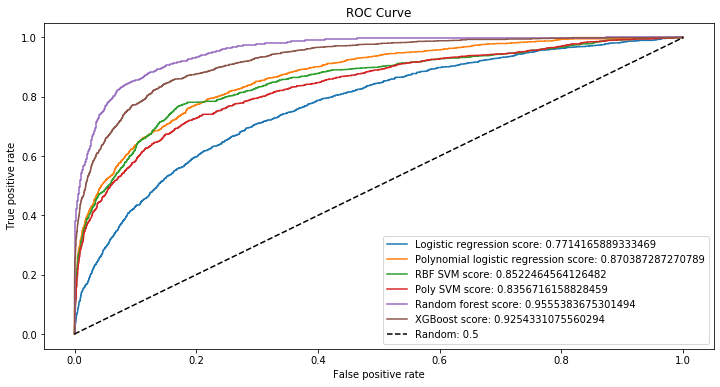

In [134]:
# plot ROC curve
def roc_plotting(model_names, scores, fpr, tpr):
    plt.figure(figsize=(12,6), linewidth=1)
    for name in model_names:
        x=fpr[name]
        y=tpr[name]
        score=scores[name]
        label= name +" score: " + str(score)
        plt.plot(x,y,label=label)
    plt.plot([0,1],[0,1],"k--",label="Random: 0.5")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.savefig("roc_results_ratios.png")
    plt.show()
    
roc_plotting(model_names, auc_scores, fpr_set, tpr_set)

**Remark**: Random forest has the highest AUC score (0.96), which means there is a 96% chance that the model ranks a random positive (churned) more highly than a random negative (stayed). 

In [97]:
# evaluate performance on test data

X_test_poly2=poly2.transform(X_test)

In [111]:
# check accuracy, precision and recall on unseen data
cal_evaluation(models, model_names, X_test, X_test_poly2,y_test)

Logistic regression
Accuracy is: 0.82
Precision is: 0.6512820512820513
Recall is: 0.24950884086444008
   
Polynomial logistic regression
Accuracy is: 0.864
Precision is: 0.7435158501440923
Recall is: 0.5068762278978389
   
RBF SVM
Accuracy is: 0.8688
Precision is: 0.8494208494208494
Recall is: 0.43222003929273084
   
Poly SVM
Accuracy is: 0.868
Precision is: 0.8977777777777778
Recall is: 0.3968565815324165
   
Random forest
Accuracy is: 0.8696
Precision is: 0.7961165048543689
Recall is: 0.48330058939096265
   
XGBoost
Accuracy is: 0.8668
Precision is: 0.7619047619047619
Recall is: 0.5029469548133595
   


**Remark**: We look at recall, as it is of more importance to us, and find that polynomial logistic regression (degree=2) has the highest recall (0.51), followed by XGboost (0.50) and random forest (0.48). 

As for precision, SVM with poly kernel has the highest precision (0.90), with the second and third highest precision achieved by SVM with RBF kernel (0.85) and random forest (0.80).

Our sample data has a ratio of 4:1 for negative and positive data (sample imbalance). Also, high accuracy could be attributed to high proportion of true negatives. Here, we pay more attention to precision and recall than accuracy. 

In [112]:
# check classification report 
cal_report(models,model_names,X_test, X_test_poly2, y_test)

Logistic regression
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1991
           1       0.65      0.25      0.36       509

    accuracy                           0.82      2500
   macro avg       0.74      0.61      0.63      2500
weighted avg       0.80      0.82      0.79      2500

-------------------
Polynomial logistic regression
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1991
           1       0.74      0.51      0.60       509

    accuracy                           0.86      2500
   macro avg       0.81      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500

-------------------
RBF SVM
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1991
           1       0.85      0.43      0.57       509

    accuracy                           0.87      2500
   macro avg       0.86      

**Remark**: With regards to f1 score, XGboost achieved the highest f1 score (0.61), while both random forest and polynomial logistic regression (degree=2) achieved the second highest score (0.6). 

In [136]:
# check auc score and roc curve
auc_test={}
fpr_test={}
tpr_test={}

cal_auc_roc(models, model_names, X_test, X_test_poly2, y_test, auc_test, fpr_test, tpr_test)


Logistic regression
AUC score: 0.7799222236804323
-------------------
Polynomial logistic regression
AUC score: 0.8631898553313092
-------------------
RBF SVM
AUC score: 0.8399492213980594
-------------------
Poly SVM
AUC score: 0.8390399232696446
-------------------
Random forest
AUC score: 0.8679983304043046
-------------------
XGBoost
AUC score: 0.8641963491902164
-------------------


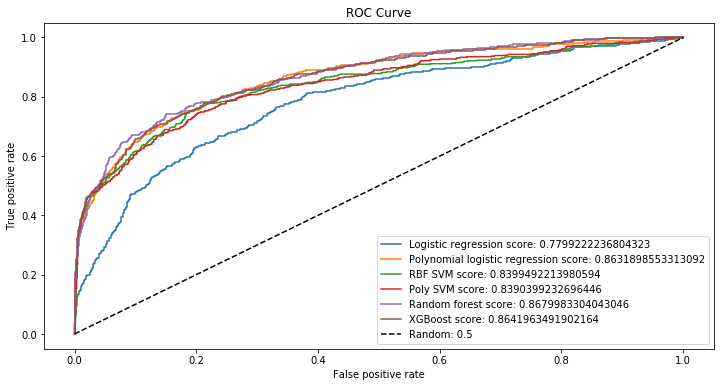

In [158]:
roc_plotting(model_names, auc_test, fpr_test, tpr_test)

**Remark**: AS shown above, random forest has the highest auc score (0.87), followed by polynomial logistic regression (0.86) and XGboost (0.86). 

## 6. Feature Selection

**Not all features are created equal.**

By removing features that are irrelevant or redundant to the problem, you can fine-tune feature space to a subset that are most relevant to the preodictive modelling problem we are working on. Unlike dimensionality reduction method which reduces the number of attributes by creating new attributes, feature selection include or exclude attributes without changing them. 

**Objectives of feature selection**:
- improve prediction performance
- improve prediction speed and cost-effectiveness
- help better understand the underlying prediction logic

**Method 1: Regularization (Lasso & Ridge)**:
Regularization (L1 norm and L2 norm) bakes in the concept of feature selection, as they actively punish or discount the contribution of features while model is being created. **We will use Lasso and Ridge here.**

**Other Methods**:
Of course there are many other feature selection techniques, which could be further explored. 
- Filter Methods: Chi square test, information gain, correlation
- Wrapper Methods: recursive feature elimination algorithm
- Embedded Methods: regularization (Lassom Ridge, Elastic Net)

In [188]:
# check feature importance from ridge regression model (logistic + L2)
lg_l2=log_primal_Grid.best_estimator_

In [190]:
# for comparison, let's train a lasso regression model (logistic + L1)
param_grid={"C":[0.1,0.5,1,10,50,100],
           "max_iter":[250],
           "fit_intercept":[True],
           "intercept_scaling":[1],
           "penalty":["l1"],
           "tol":[0.00001, 0.0001, 0.000001]}
log_primal_Grid_l1=GridSearchCV(LogisticRegression(solver="liblinear"),
                                               param_grid,cv=10,
                                               refit=True, verbose=0)

log_primal_Grid_l1.fit(X_train, y_train)
lg_l1=log_primal_Grid_l1.best_estimator_

In [193]:
# rank features based on its importance (scale of coefficients) in a descending order
lg_models=[lg_l2,lg_l1]
def lg_coef_des(models, model_names, columns):
    for model, name in zip(models, model_names):
        indices=np.argsort(abs(model.coef_[0]))[::-1]
        print(name)
        for i in range(len(columns)):
            print("{0} : {1}".format(columns[indices[i]], 
                          round(model.coef_[0][indices[i]],4))) 
        print("-------------------")
            

lg_columns=X_test.columns
lg_names=["Ridge Regression", "Lasso Regression"]
lg_coef_des(lg_models, lg_names, lg_columns)

Ridge Regression
CreditScoreByAge : -8.5223
CreditScore : 2.2509
IsActiveMember : -0.9963
Balance : 0.678
Geography_Germany : 0.5534
Gender : -0.489
NumOfProducts : -0.3329
Tenure : -0.247
Geography_France : -0.2353
Geography_Spain : -0.2093
TenureByAge : 0.1909
Age : 0.1024
EstimatedSalary : 0.0707
BalanceProductsRatio : 0.0651
HasCrCard : -0.0016
-------------------
Lasso Regression
CreditScoreByAge : -8.1464
CreditScore : 2.0998
IsActiveMember : -0.9896
Geography_Germany : 0.6409
Balance : 0.6376
Gender : -0.4863
NumOfProducts : -0.3053
Age : 0.1905
Tenure : -0.1568
Geography_France : -0.1456
Geography_Spain : -0.1169
BalanceProductsRatio : 0.0925
EstimatedSalary : 0.053
HasCrCard : -0.0007
TenureByAge : 0.0
-------------------


**Remark**: As shown above, out of four least important features, both ridge and lasso regression voted for these three features: HasCrCard, EstimatedSalary and BalanceProductsRatio. Let's remove these three features and see if it improve model performance.

Moreover, for lasso regression, TenureByAge has zero impact in predicting target valuee. Thus this will be removed as well. 

In [200]:
# remove features + lasso regression model
X_train_rmv=X_train.drop(["BalanceProductsRatio",
                             "EstimatedSalary",
                             "HasCrCard",
                             "TenureByAge"], axis=1)

param_grid={"C":[0.1,0.5,1,10,50,100],
           "max_iter":[250],
           "fit_intercept":[True],
           "intercept_scaling":[1],
           "penalty":["l1"],
           "tol":[0.00001, 0.0001, 0.000001]}

log_Grid_l1_rmv=GridSearchCV(LogisticRegression(solver="liblinear"),
                                               param_grid,cv=10,
                                               refit=True, verbose=0)

log_Grid_l1_rmv.fit(X_train_rmv, y_train)
lg_l1_rmv=log_Grid_l1_rmv.best_estimator_

In [201]:
# remove features + ridge regression model
X_train_rmv2=X_train.drop(["BalanceProductsRatio",
                             "EstimatedSalary",
                             "HasCrCard"], axis=1)

param_grid={"C":[0.1,0.5,1,10,50,100],
           "max_iter":[250],
           "fit_intercept":[True],
           "intercept_scaling":[1],
           "penalty":["l2"],
           "tol":[0.00001, 0.0001, 0.000001]}

log_Grid_l2_rmv=GridSearchCV(LogisticRegression(solver="lbfgs"),
                                               param_grid,cv=10,
                                               refit=True, verbose=0)

log_Grid_l2_rmv.fit(X_train_rmv2, y_train)
lg_l2_rmv=log_Grid_l2_rmv.best_estimator_

In [205]:
# evaluate ridge, lasso, ridge with less features, lasso with less features
X_test_rmv=X_test.drop(["BalanceProductsRatio",
                             "EstimatedSalary",
                             "HasCrCard",
                             "TenureByAge"], axis=1)
X_test_rmv2=X_test.drop(["BalanceProductsRatio",
                             "EstimatedSalary",
                             "HasCrCard"], axis=1)

print("Lasso Regression Before & After")
print(classification_report(y_test, lg_l1.predict(X_test)))
print(classification_report(y_test, lg_l1_rmv.predict(X_test_rmv)))
print("-------------------")
print("Ridge Regression Before & After")
print(classification_report(y_test, lg_l2.predict(X_test)))
print(classification_report(y_test, lg_l2_rmv.predict(X_test_rmv2)))

Lasso Regression Before & After
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1991
           1       0.64      0.24      0.35       509

    accuracy                           0.82      2500
   macro avg       0.74      0.60      0.62      2500
weighted avg       0.79      0.82      0.78      2500

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1991
           1       0.65      0.25      0.36       509

    accuracy                           0.82      2500
   macro avg       0.74      0.61      0.63      2500
weighted avg       0.80      0.82      0.79      2500

-------------------
Ridge Regression Before & After
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1991
           1       0.65      0.25      0.36       509

    accuracy                           0.82      2500
   macro avg       0.74      0.61      0.63 

**Remark**: As shown in the data, there are indeed some provements after our feature selection process. For example, all three metrics (precision, recall and F1 score) have increased by 0.01 after eliminating less important features in lasso regression. Similarly, ridge regression has its precision improved by 0.01 after feature elimination. The rest metrics remained the same. No drop in other metrics are witnessed. 

Although the improvement is far from "drastically significant", it indicates how feature selection could play a game-changing role in enhancing model performance. 

## Summary

This project can help business owners to identify customers who are likely to churn and provides the visibility to know what is driving that behaviour. Alert and compensation sheme could be set up accordingly. It generates the insights business owners need while saving managers from days or weeks of tedious analysis. 

Business owners could deploy the model on their server and feed it with customer-related data. Furthermore, business operators can choose to set up a threshold together with an alert scheme. For example, company can set the threshold to be 0.8. Once setup is done, an alert will be sent to designated managers whenever the predicted likelihood of churn is over 0.8. Upon receival of alerts, managers could take immediate actions to prevent customer churn.  

### Further improvement to enhance model performance?
1. Expand training data from operation-related to experience-related 
   * **operation-related data**: repeated visit, latest purchase
   * **experience-related data**: degree of satisfaction, likelihood to recommend
   * Help models find more value-added features to enhance classification accuracy.
2. Ensemble models with weak performance to create a new model with strong performance.
   * Use VottingClassifier to combine prediction results from multiple classification models.
   * Use **hard voting** (majority vote) or **soft voting** (argmax probability) for optimized performance.